In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
from disambiguation import Benchmark
import disambiguation.processing as dp

In [2]:
filled_1850 = pd.read_csv("../data/dwelling_filled_sum_1850_mn.csv")
census_1880 = pd.read_csv("../data/census_1880_mn_v04.csv")
cd_1880 = pd.read_csv("../data/cd_1880.csv")
disamb_1880 = pd.read_csv("../data/disambiguated-21-5-2020.csv")

/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Problem: We want to figure out block numbers for 1850 data. This is somewhat similar to figuring out street names in how much information there will be available. Here we'll also explore the issues inherant with combining census and city directory data from 1880 in the benchmarking process since block number is in city directory data and the granualarity we need is in the census data

1. Work out approaches for figuring out block numbers
    - Also applicable to street name problem
2. Understand combining city directory and census information from 1880, as this isn't inherently entirely accurate

In [3]:
filled_1850.head()

,BLOCK_NUM,CD_ADDRESS,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_NUM,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,CENSUS_GEOG,...,CENSUS_PLACE,CENSUS_RACE,CENSUS_REEL_HOUSEHOLD,CENSUS_SEQ_NUM,CENSUS_SERIALP,CENSUS_SEX,CENSUS_WARD_NUM,selected,spatial_weight,spatial_weight_sum
0,680.0,97 Cedar,NaN,NaN,32,4610,29.0,29.0,2,NEW YORK WARD 1 EASTERN DIVISION,...,MANHATTAN,120,534,1,2044375,1,1,NaN,NaN,NaN
1,680.0,97 Cedar,NaN,NaN,17,4610,29.0,29.0,2,NEW YORK WARD 1 EASTERN DIVISION,...,MANHATTAN,120,534,2,2044375,1,1,NaN,NaN,NaN
2,680.0,97 Cedar,-74.011293,40.709066,33,4610,29.0,59.0,12,NEW YORK WARD 1 WESTERN DIVISION,...,MANHATTAN,120,534,1,2045438,1,1,1.0,1.9,3.77
3,680.0,97 Cedar,NaN,NaN,30,4610,29.0,59.0,12,NEW YORK WARD 1 WESTERN DIVISION,...,MANHATTAN,120,534,2,2045438,2,1,NaN,NaN,NaN
4,680.0,97 Cedar,NaN,NaN,12,4610,29.0,59.0,12,NEW YORK WARD 1 WESTERN DIVISION,...,MANHATTAN,120,534,3,2045438,1,1,NaN,NaN,NaN


In [4]:
census_1880.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117479 entries, 0 to 1117478
Data columns (total 42 columns):
OBJECTID.x           1117479 non-null int64
CENSUS_MERGEID       1117479 non-null object
CENSUS_SERIALB       1117479 non-null int64
CENSUS_SERIAL        1117479 non-null int64
CENSUS_PERNUM        1117479 non-null int64
CENSUS_RECIDUS       1117158 non-null object
CENSUS_REEL          1117479 non-null int64
CENSUS_VOLUME        1117479 non-null int64
CENSUS_PAGENUM       1117479 non-null int64
CENSUS_NAMEFRSTB     1117479 non-null object
CENSUS_NAMELASTB     1117479 non-null object
CENSUS_RELATE        1117479 non-null int64
CENSUS_RELATE_STR    1117479 non-null object
CENSUS_AGE           1117479 non-null int64
CENSUS_SEXB          1117479 non-null int64
CENSUS_RACENAMEB     1117479 non-null object
CENSUS_RACEB         1117479 non-null int64
CENSUS_NPERHHB       1117479 non-null int64
CENSUS_OCCLABELB     1117322 non-null object
CENSUS_SEIUSBN       1117479 non-null int64


In [5]:
cd_1880.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223436 entries, 0 to 223435
Data columns (total 46 columns):
OBJECTID             223436 non-null int64
MATCH_ADDR           223436 non-null object
ADDR_TYPE            223436 non-null object
ADDNUM               223436 non-null int64
ADDNUMFROM           223436 non-null float64
ADDNUMTO             223430 non-null float64
SIDE                 223436 non-null object
STPREDIR             99132 non-null object
STPRETYPE            410 non-null object
STNAME               223436 non-null object
STTYPE               217746 non-null object
STDIR                0 non-null float64
STADDR               223436 non-null object
CITY                 223436 non-null object
COUNTY               0 non-null float64
STATE                223436 non-null object
ZIP                  0 non-null float64
COUNTRY              223436 non-null object
X                    223436 non-null float64
Y                    223436 non-null float64
STREETID             0 

In [6]:
print("Number of Dwellings in 1880 Census:", census_1880["CENSUS_ADDRESS"].nunique())
print("Number of Dwellings in 1880 City Directory:", cd_1880["MATCH_ADDR"].nunique())
print("Number of Dwellings in 1850:", filled_1850.groupby(["CENSUS_WARD_NUM", "CENSUS_DWELLING_NUM"]).ngroups)

Number of Dwellings in 1880 Census: 57961
Number of Dwellings in 1880 City Directory: 58164
Number of Dwellings in 1850: 19825


To me, this suggests that we can use the city directory information from 1880 directory instead of combining the two. But this is something to double check.

### Understand Block Number

In [8]:
def uniqueness(df, level, col):
    df_check = df[[level, col]]
    df2 = df_check.groupby(level).apply(lambda x: x[col].unique())
    d = df2.to_dict()
    for key1 in d:
        for key2 in d:
            if key1 != key2:
                check = any(item in d[key1] for item in d[key2])
                if check is True:
                    print(key1, key2)
                    raise Exception(str(col) + " numbers are not unique")
    return True

In [9]:
uniqueness(filled_1850, "CENSUS_WARD_NUM","BLOCK_NUM")

2 4


Exception: BLOCK_NUM numbers are not unique

In [10]:
uniqueness(cd_1880, "WARD_NUM","CD_BLOCK_NUM")

1 2


Exception: CD_BLOCK_NUM numbers are not unique

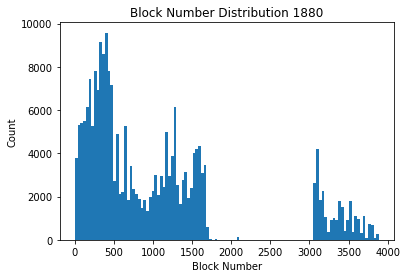

In [15]:
plt.hist(cd_1880["CD_BLOCK_NUM"], bins = "auto")
plt.title("Block Number Distribution 1880")
plt.xlabel("Block Number")
plt.ylabel("Count")
plt.show()

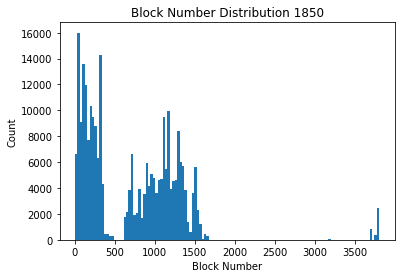

In [16]:
plt.hist(filled_1850["BLOCK_NUM"], bins = "auto")
plt.title("Block Number Distribution 1850")
plt.xlabel("Block Number")
plt.ylabel("Count")
plt.show()

In [18]:
print("Number of unique block numbers in 1880:", cd_1880["CD_BLOCK_NUM"].nunique())
print("Number of unique block numbers in 1850:", filled_1850["BLOCK_NUM"].nunique())

Number of unique block numbers in 1880: 2054
Number of unique block numbers in 1850: 1012


So the distributions are pretty similar, although of 1880 has far more numbers. Let's get a sense of wards, by looking at the historically chose sample with overlap

In [25]:
print("Wards in 1880:", cd_1880["WARD_NUM"].unique())
print("Wards in 1850:", filled_1850["CENSUS_WARD_NUM"].unique())

Wards in 1880: [ 8 16 22 19  4 20  2 11 10 13 18 12 17 15 21  3  9  6  7 14  1  5]
Wards in 1850: [ 1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 12 19]


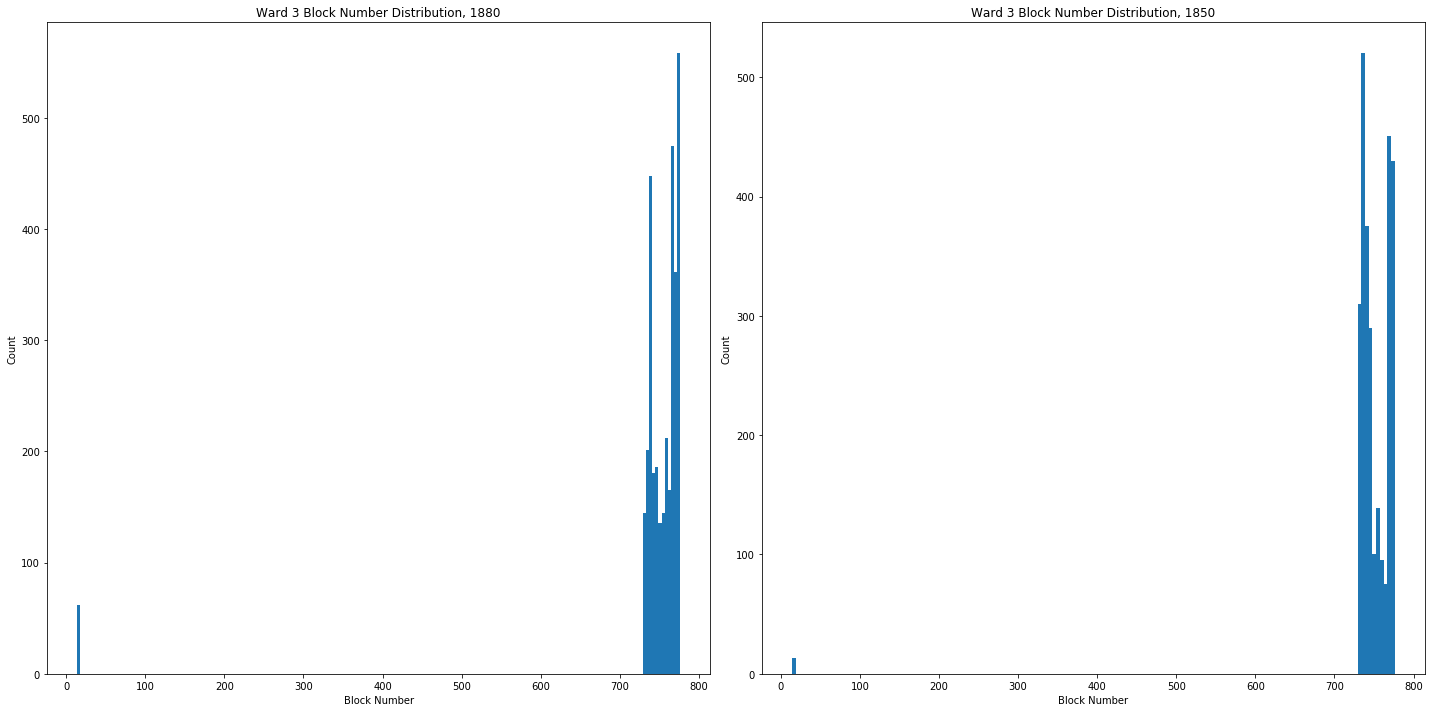

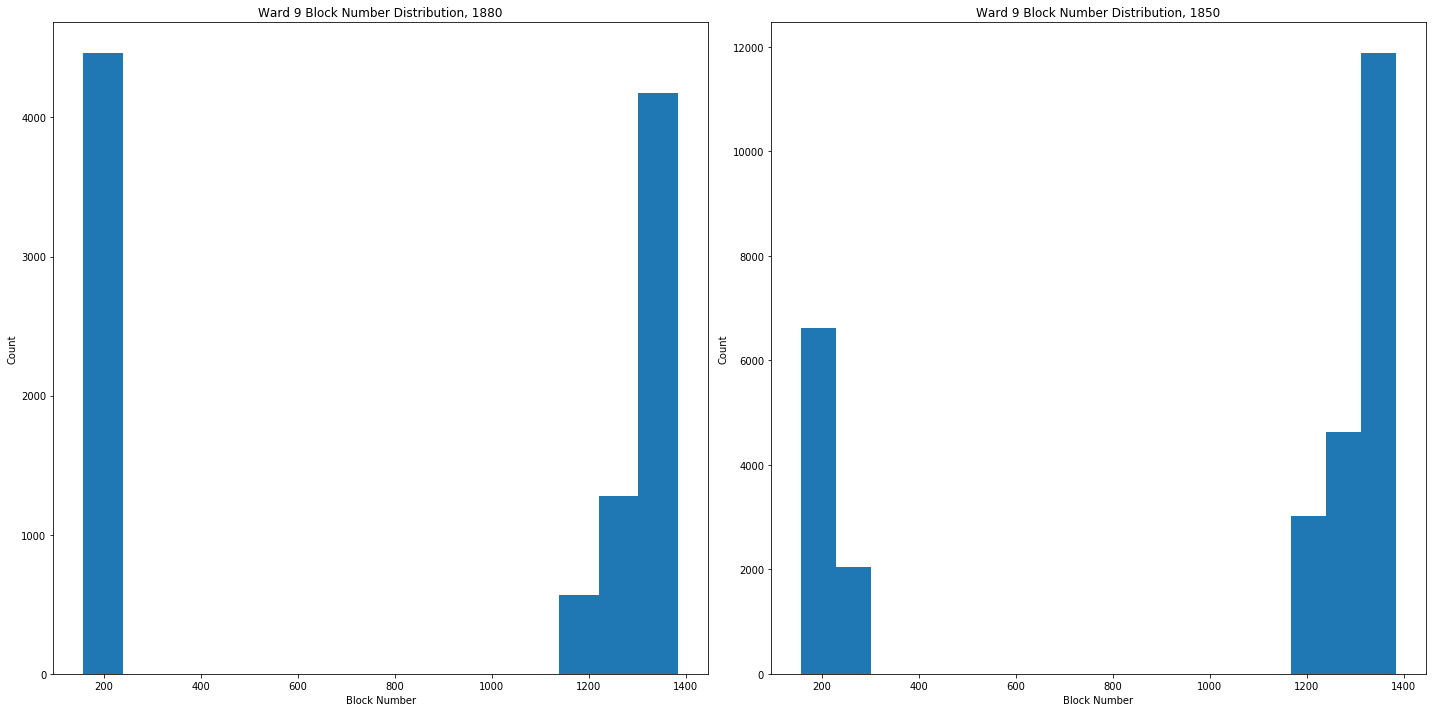

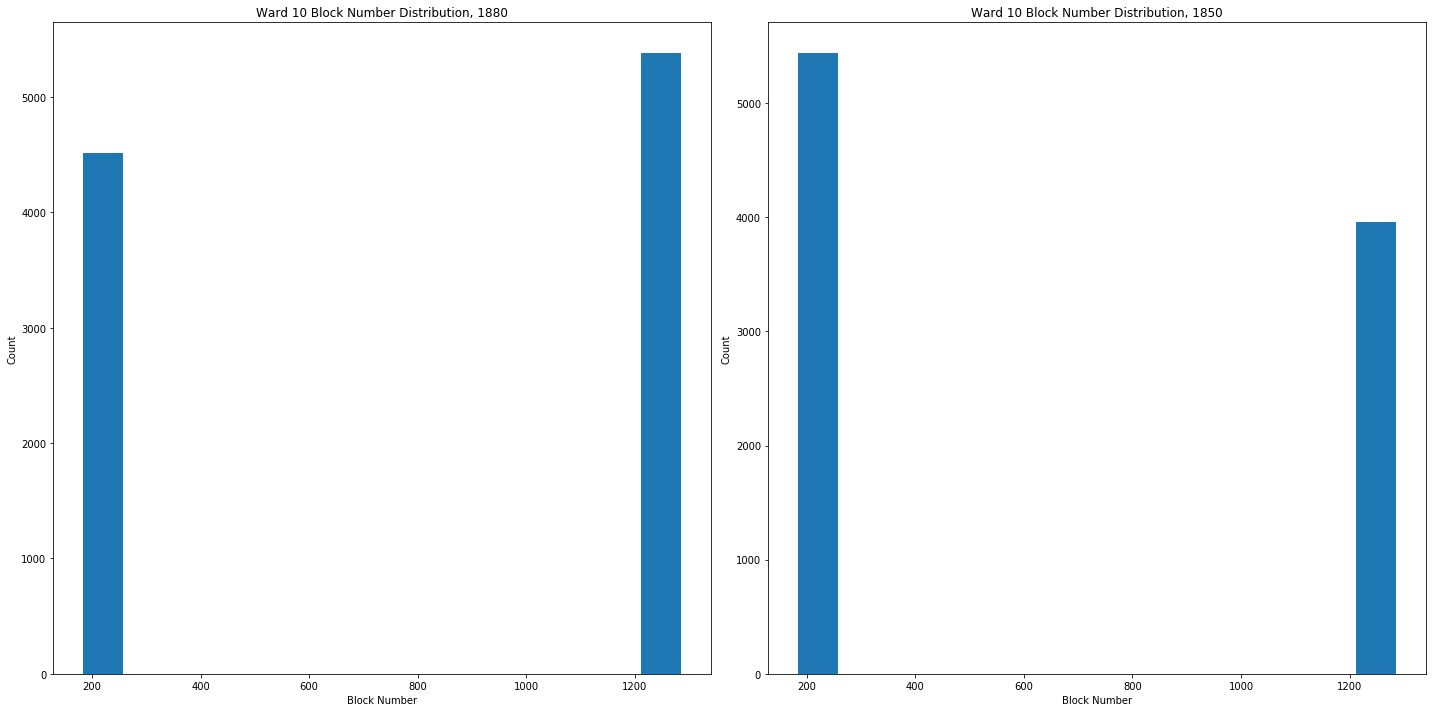

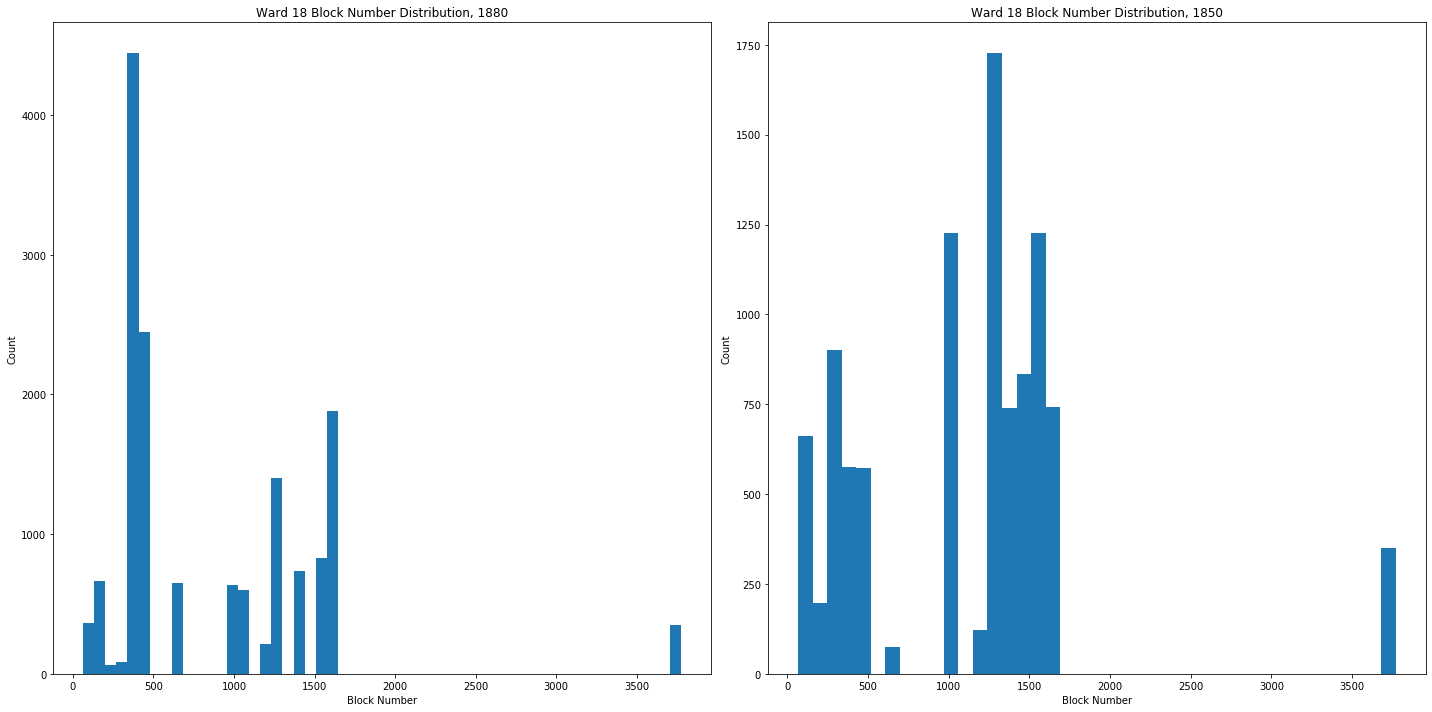

In [29]:
#wards present in both years from previously selected sample
wards = [3, 9, 10, 18]
for ward in wards:
    fig, ax = plt.subplots(1, 2, figsize=(20,10))
    plot_1880 = cd_1880[cd_1880["WARD_NUM"] == ward]
    plot_1850 = filled_1850[filled_1850["CENSUS_WARD_NUM"] == ward]
    
    ax[0].hist(plot_1880["CD_BLOCK_NUM"], bins = "auto")
    ax[0].set_title("Ward "+str(ward)+" Block Number Distribution, 1880")
    ax[0].set_xlabel("Block Number")
    ax[0].set_ylabel("Count")
    
    ax[1].hist(plot_1850["BLOCK_NUM"], bins = "auto")
    ax[1].set_title("Ward "+str(ward)+" Block Number Distribution, 1850")
    ax[1].set_xlabel("Block Number")
    ax[1].set_ylabel("Count")
    
    plt.tight_layout()
    plt.show()

Again, very similar block number distributions between years, ward specific, this indicates again that using 1880 to train for 1850 will work

### Consider Feature Options (this will also be important for street name)

One of the issues with this approach is that we don't really have many features that actually help us understand the information we have. I think getting ahold of information from the geocoder will really help with the geography of the situation aspect. But what we have right now isn't really enough. Let's start looking at what we know from 1850 about what's inbetween

In [7]:
street_nums = []
current_street = {}
indices = []
current_index = []
first_index = census_1850_dwellings["Street_Name"].first_valid_index()
streets = [census_1850_dwellings["Street_Name"].iloc[first_index]]

for row in census_1850_dwellings.itertuples():
    if row.Index < first_index:
        continue
        
    if type(row.Street_Name) == float: #This is to check for nans bc they're formatted as a float
        current_index.append(row.Index)
        
    elif streets[-1] == row.Street_Name:
        current_street[row.Index] = row.Dwelling_Number
        
    else:
        streets.append(row.Street_Name)
        street_nums.append(current_street)
        current_street = {}
        current_street[row.Index] = row.Dwelling_Number
        indices.append(current_index)
        current_index = []

NameError: name 'census_1850_dwellings' is not defined

In [3]:
#I need to look at the geography of this, and try to get a sense of where these things are
dwellings_1850 = filled_1850.groupby(["CENSUS_WARD_NUM", "CENSUS_DWELLING_NUM"], as_index = False).first()
dwellings_1850.head(30)

,CENSUS_WARD_NUM,CENSUS_DWELLING_NUM,BLOCK_NUM,CD_ADDRESS,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,...,CENSUS_PAGENO_HOUSEHOLD,CENSUS_PLACE,CENSUS_RACE,CENSUS_REEL_HOUSEHOLD,CENSUS_SEQ_NUM,CENSUS_SERIALP,CENSUS_SEX,selected,spatial_weight,spatial_weight_sum
0,1,1.0,3794.0,37 South,-74.008250,40.703128,49,4610,1.0,84,...,70,MANHATTAN,120,534,1,2044262,1,1.0,2.00,NaN
1,1,2.0,NaN,NaN,NaN,NaN,24,4610,2.0,3,...,100,MANHATTAN,120,534,1,2044348,1,NaN,NaN,NaN
2,1,3.0,NaN,NaN,NaN,NaN,26,4610,3.0,1,...,100,MANHATTAN,120,534,1,2044349,1,NaN,NaN,NaN
3,1,4.0,713.0,76 Liberty,-74.011071,40.709385,23,4610,4.0,1,...,100,MANHATTAN,120,534,1,2044350,1,1.0,1.74,NaN
4,1,5.0,NaN,NaN,NaN,NaN,30,4610,5.0,3,...,100,MANHATTAN,120,534,1,2044351,1,NaN,NaN,NaN
5,1,6.0,709.0,46 Cedar,-74.009067,40.707572,25,4610,6.0,3,...,110,MANHATTAN,120,534,1,2044352,1,1.0,2.00,NaN
6,1,7.0,682.0,102 Liberty |,-74.011747,40.709673,22,4610,7.0,1,...,110,MANHATTAN,120,534,1,2044353,1,1.0,1.95,NaN
7,1,8.0,NaN,NaN,NaN,NaN,35,4610,8.0,8,...,110,MANHATTAN,120,534,1,2044354,1,NaN,NaN,NaN
8,1,9.0,718.0,163 Pearl,-74.007680,40.705869,22,4610,9.0,1,...,110,MANHATTAN,120,534,1,2044355,1,1.0,1.96,NaN
9,1,10.0,NaN,NaN,NaN,NaN,40,4610,10.0,2,...,110,MANHATTAN,120,534,1,2044356,1,NaN,NaN,NaN


In [48]:
disamb_1880.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151046 entries, 0 to 151045
Data columns (total 36 columns):
CD_ED                151046 non-null float64
CD_FINAL_HOUSENUM    151046 non-null object
CD_FIRST_NAME        151046 non-null object
CD_ID                151046 non-null object
CD_LAST_NAME         151046 non-null object
CD_OCCUPATION        143375 non-null object
CENSUS_AGE           151046 non-null int64
CENSUS_ID            151046 non-null object
CENSUS_MATCH_ADDR    151046 non-null object
CENSUS_NAMEFRSTB     151046 non-null object
CENSUS_NAMELASTB     151046 non-null object
CENSUS_OCCLABELB     151039 non-null object
CENSUS_SEGMENT_ID    151046 non-null int64
LAT                  151046 non-null float64
LONG                 151046 non-null float64
MATCH_ADDR           151046 non-null object
OBJECTID             151046 non-null int64
OBJECTID.x           151046 non-null int64
WARD_NUM             151046 non-null int64
age_score            151046 non-null int64
anchor      

In [7]:
# Should consider restructuring this
# If we're going off order, we really need the census data, because that has an enumeration order that the cd doesn't
elastic_match = pd.read_csv("../data/es-1880-21-5-2020.csv", sep='\t', engine='python')
match = dp.elastic_to_disamb(elastic_match, cd_1880)

disamb_1880_benchmark = Benchmark(match, census_1880, cd_1880)

disamb_1880_benchmark.set_confidence("confidence") #currently this actually doesn't do anything
disamb_1880_benchmark.set_disambiguated(disamb_1880) #this doesn't do anything
disamb_1880_benchmark.run_benchmarking()
all_1880 = disamb_1880_benchmark.get_benchmark_results()
all_1880.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151046 entries, 0 to 151045
Data columns (total 40 columns):
OBJECTID.x              151046 non-null int64
CENSUS_NAMEFRSTB        151046 non-null object
CENSUS_NAMELASTB        151046 non-null object
CENSUS_AGE              151046 non-null int64
CENSUS_OCCLABELB        151039 non-null object
CENSUS_MATCH_ADDR       151046 non-null object
CENSUS_SEGMENT_ID       151046 non-null int64
WARD_NUM                151046 non-null int64
CD_ED                   151046 non-null float64
OBJECTID                151046 non-null int64
MATCH_ADDR              151046 non-null object
CD_FIRST_NAME           151046 non-null object
CD_LAST_NAME            151046 non-null object
CD_OCCUPATION           143375 non-null object
CD_FINAL_HOUSENUM       151046 non-null object
jw_fn                   151046 non-null float64
jw_ln                   151046 non-null float64
jw_score                151046 non-null float64
occ_listed              151046 non-null int6

In [8]:
all_1880 = all_1880[all_1880["selected"] == 1]
all_1880.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105540 entries, 0 to 151045
Data columns (total 40 columns):
OBJECTID.x              105540 non-null int64
CENSUS_NAMEFRSTB        105540 non-null object
CENSUS_NAMELASTB        105540 non-null object
CENSUS_AGE              105540 non-null int64
CENSUS_OCCLABELB        105538 non-null object
CENSUS_MATCH_ADDR       105540 non-null object
CENSUS_SEGMENT_ID       105540 non-null int64
WARD_NUM                105540 non-null int64
CD_ED                   105540 non-null float64
OBJECTID                105540 non-null int64
MATCH_ADDR              105540 non-null object
CD_FIRST_NAME           105540 non-null object
CD_LAST_NAME            105540 non-null object
CD_OCCUPATION           99909 non-null object
CD_FINAL_HOUSENUM       105540 non-null object
jw_fn                   105540 non-null float64
jw_ln                   105540 non-null float64
jw_score                105540 non-null float64
occ_listed              105540 non-null int64

In [12]:
all_1880[["OBJECTID.x", "OBJECTID", "CD_ID"]].head(10)

,OBJECTID.x,OBJECTID,CD_ID
0,862548,3,CD_3
1,795510,4,CD_4
2,978306,6,CD_6
3,56054,8,CD_8
4,522583,13,CD_13
5,580645,14,CD_14
6,330206,15,CD_15
7,855850,16,CD_16
8,796365,18,CD_18
10,313482,21,CD_21


In [19]:
dwellings_1880 = all_1880.groupby("CENSUS_MATCH_ADDR", as_index = False).first()
dwellings_1880 = dwellings_1880.merge(cd_1880[["OBJECTID", "CD_BLOCK_NUM"]], how = "left", on = "OBJECTID")
dwellings_1880_ordered = census_1880[["OBJECTID.x"]].merge(dwellings_1880, on = "OBJECTID.x", how = "left")
dwellings_1880_ordered.head()

,OBJECTID.x,CENSUS_MATCH_ADDR,CENSUS_NAMEFRSTB,CENSUS_NAMELASTB,CENSUS_AGE,CENSUS_OCCLABELB,CENSUS_SEGMENT_ID,WARD_NUM,CD_ED,OBJECTID,...,cd_hn,cen_hn,cd_add_cln,cen_add_cln,add_match,dist,dist_weight,selected,graph_ID,CD_BLOCK_NUM
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
dwellings_1880_ordered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1117479 entries, 0 to 1117478
Data columns (total 41 columns):
OBJECTID.x              1117479 non-null int64
CENSUS_MATCH_ADDR       38735 non-null object
CENSUS_NAMEFRSTB        38735 non-null object
CENSUS_NAMELASTB        38735 non-null object
CENSUS_AGE              38735 non-null float64
CENSUS_OCCLABELB        38735 non-null object
CENSUS_SEGMENT_ID       38735 non-null float64
WARD_NUM                38735 non-null float64
CD_ED                   38735 non-null float64
OBJECTID                38735 non-null float64
MATCH_ADDR              38735 non-null object
CD_FIRST_NAME           38735 non-null object
CD_LAST_NAME            38735 non-null object
CD_OCCUPATION           37186 non-null object
CD_FINAL_HOUSENUM       38735 non-null object
jw_fn                   38735 non-null float64
jw_ln                   38735 non-null float64
jw_score                38735 non-null float64
occ_listed              38735 non-null float64
age

In [17]:
#using objectid is probably not ideal, it would be great to create a consistant id in the elastic search process

dwellings_1880.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38735 entries, 0 to 38734
Data columns (total 41 columns):
CENSUS_MATCH_ADDR       38735 non-null object
OBJECTID.x              38735 non-null int64
CENSUS_NAMEFRSTB        38735 non-null object
CENSUS_NAMELASTB        38735 non-null object
CENSUS_AGE              38735 non-null int64
CENSUS_OCCLABELB        38735 non-null object
CENSUS_SEGMENT_ID       38735 non-null int64
WARD_NUM                38735 non-null int64
CD_ED                   38735 non-null float64
OBJECTID                38735 non-null int64
MATCH_ADDR              38735 non-null object
CD_FIRST_NAME           38735 non-null object
CD_LAST_NAME            38735 non-null object
CD_OCCUPATION           37186 non-null object
CD_FINAL_HOUSENUM       38735 non-null object
jw_fn                   38735 non-null float64
jw_ln                   38735 non-null float64
jw_score                38735 non-null float64
occ_listed              38735 non-null int64
age_score          

In [18]:
dwellings_1880.head(30)

,CENSUS_MATCH_ADDR,OBJECTID.x,CENSUS_NAMEFRSTB,CENSUS_NAMELASTB,CENSUS_AGE,CENSUS_OCCLABELB,CENSUS_SEGMENT_ID,WARD_NUM,CD_ED,OBJECTID,...,cd_hn,cen_hn,cd_add_cln,cen_add_cln,add_match,dist,dist_weight,selected,graph_ID,CD_BLOCK_NUM
0,"1 125TH ST E, NYC-Manhattan, NY",1110483,CHARLES,CHASE,47,COM. MERCHANT,5383,12,649.0,192954,...,1,1,ST,None,0.1,8.352934,0.57,1.0,88753,3622.0
1,"1 126TH ST W, NYC-Manhattan, NY",1109894,HENRY,SELLECK,10,*,5470,12,649.0,34220,...,1,1,ST,None,0.1,9.602452,0.54,1.0,15474,3625.0
2,"1 127TH ST W, NYC-Manhattan, NY",1111085,FREDERIKA,BRANDES,20,AT HOME,5491,12,650.0,205113,...,1,1,ST,None,0.1,32.741501,0.39,1.0,94775,3627.0
3,"1 128TH ST E, NYC-Manhattan, NY",1111778,GARNUS,BAKER,20,NO OCCUPATION,5462,12,650.0,217466,...,44,1,ST,None,0.0,177.049318,0.19,1.0,100507,3633.0
4,"1 16TH ST W, NYC-Manhattan, NY",302103,ARON,VANDERPOOL,54,LAWYER,2370,18,186.0,16289,...,1,1,ST,None,0.1,40.417294,0.37,1.0,7278,178.0
5,"1 19TH ST W, NYC-Manhattan, NY",305492,HENRY,PARISH,20,"CLERK, TRUST CO.",2462,18,188.0,64143,...,1,1,ST,None,0.1,38.833033,0.37,1.0,29451,1250.0
6,"1 27TH ST W, NYC-Manhattan, NY",479257,EDWARD,OWEN,43,"LIQUOR, WHOLESALE",2645,21,281.0,64927,...,4,1,ST,None,0.0,33.865195,0.28,1.0,29799,1411.0
7,"1 28TH ST E, NYC-Manhattan, NY",479142,ARTHUR,WILMARTH,62,INSURANCE,2657,21,281.0,5064,...,1,1,ST,None,0.1,34.518877,0.38,1.0,2252,1415.0
8,"1 29TH ST E, NYC-Manhattan, NY",480285,EDWARD,HOUGHTON,30,CLERGYMAN,2682,21,281.0,129056,...,1,1,ST,None,0.1,32.099990,0.39,1.0,57667,1413.0
9,"1 2ND ST E, NYC-Manhattan, NY",435140,JULIUS,SMALL,22,TINSMITH,1601,17,257.0,32852,...,1,1,E SECOND ST,None,0.1,69.382147,0.34,1.0,14885,249.0
